In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

In this notebook we target processing speed optimization of the code using the approaches we learned in the first module. 
For this we first line_profile the whole code to see which functions we should target first. Then we came up with hypotheses of which methods to refactor first and with which twerks. Doing this, you will see us profiling single functions again to see where bottlenecks in the processing speed lie, which then help us to target interventions. 

## Results N = 1000 
Method: W, Self-Time: 5.199s, Percentage: 33.73%
Method: gradW, Self-Time: 3.295s, Percentage: 21.38%
Method: getPairwiseSeparations, Self-Time: 3.054s, Percentage: 19.81%
Method: getAcc, Self-Time: 1.556s, Percentage: 10.09%
Method: getDensity, Self-Time: 0.382s, Percentage: 2.48%

## Results N = 10000
Method: W, Self-Time: 699.920s, Percentage: 40.64%
Method: gradW, Self-Time: 465.638s, Percentage: 27.04%
Method: getPairwiseSeparations, Self-Time: 249.328s, Percentage: 14.48%
Method: getAcc, Self-Time: 197.522s, Percentage: 11.47%
Method: getDensity, Self-Time: 56.521s, Percentage: 3.28%

In [6]:
! python -m kernprof -l sph.py 

Wrote profile results to sph.py.lprof
Inspect results with:
python -m line_profiler -rmt "sph.py.lprof"


In [7]:
! python -m line_profiler -rmt "sph.py.lprof"

Timer unit: 1e-06 s

Total time: 9.98052 s
File: sph.py
Function: getAcc at line 110

Line #      Hits         Time  Per Hit   % Time  Line Contents
   110                                           @profile
   111                                           def getAcc( pos, vel, m, h, k, n, lmbda, nu ):
   112                                           	"""
   113                                           	Calculate the acceleration on each SPH particle
   114                                           	pos   is an N x 3 matrix of positions
   115                                           	vel   is an N x 3 matrix of velocities
   116                                           	m     is the particle mass
   117                                           	h     is the smoothing length
   118                                           	k     equation of state constant
   119                                           	n     polytropic index
   120                                           	lmbda

## Results getAcc line-profiling
The most expensive operation is the density calculation (getDensity), it consums 41.5% of the time.	The inefficiency arises from the pairwise computations involved in getPairwiseSeparations and kernel evaluations. 
The kernel gradient calculation (gradW) is with 32.8% of the total time the second most time consuming operation. The three np.sum calls contribute about 15% of the time. As these calculations are repetitive they should be streamlined.

Line profiling of old getDensity() method 

In [8]:
! python -m kernprof -l test.py 

Wrote profile results to test.py.lprof
Inspect results with:
python -m line_profiler -rmt "test.py.lprof"


In [9]:
! python -m line_profiler -rmt "test.py.lprof"

Timer unit: 1e-06 s

Total time: 0.459439 s
File: test.py
Function: getDensity at line 50

Line #      Hits         Time  Per Hit   % Time  Line Contents
    50                                           @profile
    51                                           def getDensity(r, pos, m, h):
    52                                               """
    53                                               Get Density at sampling locations from SPH particle distribution
    54                                               """
    55       301        185.0      0.6      0.0      M = r.shape[0]
    56       301     136022.0    451.9     29.6      dx, dy, dz = getPairwiseSeparations(r, pos)
    57       301     323124.0   1073.5     70.3      rho = np.sum(m * W(dx, dy, dz, h), 1).reshape((M, 1))
    58       301        108.0      0.4      0.0      return rho

  0.46 seconds - test.py:50 - getDensity


Adaptions to getDensity(): 

1. Limit Pairwise Computations: Instead of computing pairwise separations for all  N  particles, compute them only for neighbors within the smoothing length h. 
2. scipy.spatial.cKDTree: Builds a spatial index of the particle positions for efficient neighbor queries, thus reducing the need to compute all pairwise distances.
3. The kernel (W) is evaluated only for neighbors, significantly reducing the number of expensive exponential function calls.

Line profiling of rewritten getDensity() method

First check that the changes to the optimized method do not alter the result

In [2]:
! pytest -v test_w.py

============================= test session starts ==============================
platform darwin -- Python 3.11.6, pytest-8.3.4, pluggy-1.5.0 -- /Users/carlottaholzle/Desktop/KTH Assignments/Computational-Astrophysics/.venv/bin/python
cachedir: .pytest_cache
rootdir: /Users/carlottaholzle/Desktop/KTH Assignments/Computational-Astrophysics
collected 1 item                                                               

test_w.py::testW PASSED                                                  [100%]

============================== 1 passed in 0.41s ===============================


In [13]:
! pytest -v test_get_density.py

============================= test session starts ==============================
platform darwin -- Python 3.11.6, pytest-8.3.4, pluggy-1.5.0 -- /Users/carlottaholzle/Desktop/KTH Assignments/Computational-Astrophysics/.venv/bin/python
cachedir: .pytest_cache
rootdir: /Users/carlottaholzle/Desktop/KTH Assignments/Computational-Astrophysics
collected 1 item                                                               

test_get_density.py::test_get_density PASSED                             [100%]

============================== 1 passed in 0.38s ===============================


In [4]:
! python -m kernprof -l sph.py 

^C


In [10]:
! python -m line_profiler -rmt "sph.py.lprof"

Timer unit: 1e-06 s

Total time: 8.38176 s
File: sph.py
Function: getDensity at line 87

Line #      Hits         Time  Per Hit   % Time  Line Contents
    87                                           @profile
    88                                           def getDensity( r, pos, m, h ):
    89                                           	"""
    90                                           	Get Density at sampling loctions from SPH particle distribution
    91                                           	r     is an M x 3 matrix of sampling locations
    92                                           	pos   is an N x 3 matrix of SPH particle positions
    93                                           	m     is the particle mass
    94                                           	h     is the smoothing length
    95                                           	rho   is M x 1 vector of densities
    96                                           	"""
    97                                         

In [14]:
# optimized W
! python -m kernprof -l sph.py 

Wrote profile results to sph.py.lprof
Inspect results with:
python -m line_profiler -rmt "sph.py.lprof"


In [15]:
! python -m line_profiler -rmt "sph.py.lprof"

Timer unit: 1e-06 s

Total time: 5.71551 s
File: sph.py
Function: getDensity at line 87

Line #      Hits         Time  Per Hit   % Time  Line Contents
    87                                           @profile
    88                                           def getDensity( r, pos, m, h ):
    89                                           	"""
    90                                           	Get Density at sampling loctions from SPH particle distribution
    91                                           	r     is an M x 3 matrix of sampling locations
    92                                           	pos   is an N x 3 matrix of SPH particle positions
    93                                           	m     is the particle mass
    94                                           	h     is the smoothing length
    95                                           	rho   is M x 1 vector of densities
    96                                           	"""
    97                                         

Speedup: 8.38176 s - 5.72 s = 2,66 s

getPaiwiseSeperations() 


In [8]:
! pytest -v test_getPairwiseSeperations.py

============================= test session starts ==============================
platform darwin -- Python 3.11.6, pytest-8.3.4, pluggy-1.5.0 -- /Users/carlottaholzle/Desktop/KTH Assignments/Computational-Astrophysics/.venv/bin/python
cachedir: .pytest_cache
rootdir: /Users/carlottaholzle/Desktop/KTH Assignments/Computational-Astrophysics
collected 3 items                                                              

test_getPairwiseSeperations.py::test_dx PASSED                           [ 33%]
test_getPairwiseSeperations.py::test_dy PASSED                           [ 66%]
test_getPairwiseSeperations.py::test_dz PASSED                           [100%]

============================== 3 passed in 0.36s ===============================


Here we now iterated with the different getPairwiseSeperations methods. They can all be found in the file getPairwiseSeperations_optimized.py. Feel free to test them again, profile how long the code takes using them, also switching around with the size of N. You will see big differences in execution times, ours are recorded below. 

In [ ]:
! python -m kernprof -l sph_optimized.py 

In [ ]:
! python -m line_profiler -rmt "sph_optimized.py.lprof"

Timer unit: 1e-06 s

Total time: 8.37082 s
File: test.py
Function: getAcc at line 258

Line #      Hits         Time  Per Hit   % Time  Line Contents
   258                                           @profile 
   259                                           def getAcc(pos, vel, m, h, k, n, lmbda, nu):
   260                                               """
   261                                               Calculate the acceleration on each SPH particle
   262                                               """
   263       301        354.0      1.2      0.0      N = pos.shape[0]
   264       301     357324.0   1187.1      4.3      rho = getDensity(pos, pos, m, h, optimizedW)
   265                                               #rho = optimizedGetDensity(pos, pos, m, h)
   266       301       1869.0      6.2      0.0      P = getPressure(rho, k, n)
   267       301    7212858.0  23963.0     86.2      dx, dy, dz = getPairwiseSeparations_parallel(pos, pos)
   268       301     545350.0 

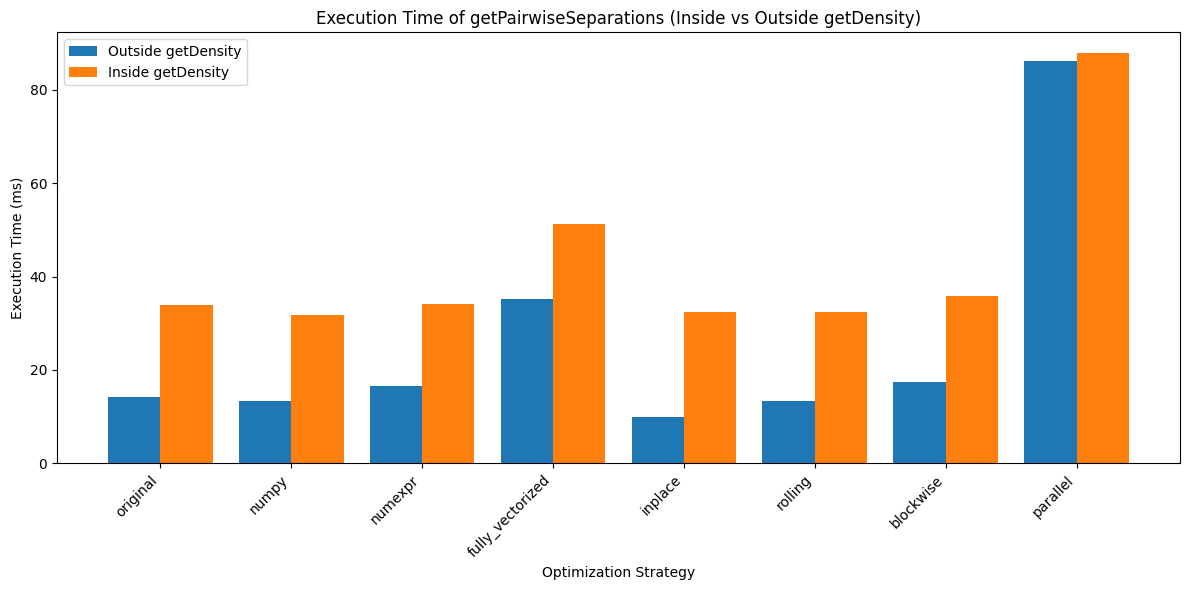

In [8]:
import matplotlib.pyplot as plt
import numpy as np

strategies = [
    "original", "numpy", "numexpr", "fully_vectorized", "inplace",
    "rolling", "blockwise", "parallel"]
strategies_extra = [ "rolling-window", "list",
    "tuple", "in-place", "block-wise 512", "block-wise 256",
    "in-place float_32", "fully_vectorized", "pairwise_workers",
    "float32 cast"
]

outside_times = [
    14.1, 13.4, 16.5, 35.2, 9.9, 13.3, 17.5, 86.2
]

inside_times = [
    33.8, 31.8, 34.2, 51.2, 32.3, 32.5, 35.9, 87.9
]

filtered_strategies, filtered_outside_times, filtered_inside_times = [], [], []
for strat, out_time, in_time in zip(strategies, outside_times, inside_times):
    if out_time is not None or in_time is not None:
        filtered_strategies.append(strat)
        filtered_outside_times.append(out_time if out_time is not None else 0)
        filtered_inside_times.append(in_time if in_time is not None else 0)

x = np.arange(len(filtered_strategies))  # label positions

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4

ax.bar(x - bar_width/2, filtered_outside_times, bar_width, label="Outside getDensity", color='tab:blue')
ax.bar(x + bar_width/2, filtered_inside_times, bar_width, label="Inside getDensity", color='tab:orange')

ax.set_xlabel("Optimization Strategy")
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Execution Time of getPairwiseSeparations (Inside vs Outside getDensity)")
ax.set_xticks(x)
ax.set_xticklabels(filtered_strategies, rotation=45, ha="right")
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [16]:
! python -m kernprof -l sph_optimized.py 

Wrote profile results to sph_optimized.py.lprof
Inspect results with:
python -m line_profiler -rmt "sph_optimized.py.lprof"


In [17]:
! python -m line_profiler -rmt "sph_optimized.py.lprof"

Timer unit: 1e-06 s

Total time: 3.35915 s
File: sph_optimized.py
Function: getDensity at line 105

Line #      Hits         Time  Per Hit   % Time  Line Contents
   105                                           @profile
   106                                           def getDensity( r, pos, m, h ):
   107                                           	"""
   108                                           	Get Density at sampling loctions from SPH particle distribution
   109                                           	r     is an M x 3 matrix of sampling locations
   110                                           	pos   is an N x 3 matrix of SPH particle positions
   111                                           	m     is the particle mass
   112                                           	h     is the smoothing length
   113                                           	rho   is M x 1 vector of densities
   114                                           	"""
   115                              

optimizing gradW(): 

In [10]:
! pytest -v test_gradW.py

============================= test session starts ==============================
platform darwin -- Python 3.11.6, pytest-8.3.4, pluggy-1.5.0 -- /Users/carlottaholzle/Desktop/KTH Assignments/Computational-Astrophysics/.venv/bin/python
cachedir: .pytest_cache
rootdir: /Users/carlottaholzle/Desktop/KTH Assignments/Computational-Astrophysics
collected 4 items                                                              

test_gradW.py::test_xyz PASSED                                           [ 25%]
test_gradW.py::test_dWx PASSED                                           [ 50%]
test_gradW.py::test_dWy PASSED                                           [ 75%]
test_gradW.py::test_dWz PASSED                                           [100%]

============================== 4 passed in 0.41s ===============================


1. float 32 - 3418635.0
2. inplace - 3837618.0
3. float32_inplace - 3673374.0
4. numexpr - 1756321.0

We again ran the code interchanging the different methods we deemed useful to gain processing speed, all results are plotted below in the figure. 

In [22]:
! python -m kernprof -l sph_optimized.py 

Wrote profile results to sph_optimized.py.lprof
Inspect results with:
python -m line_profiler -rmt "sph_optimized.py.lprof"


In [23]:
! python -m line_profiler -rmt "sph_optimized.py.lprof"

Timer unit: 1e-06 s

Total time: 8.80523 s
File: sph_optimized.py
Function: getAcc at line 221

Line #      Hits         Time  Per Hit   % Time  Line Contents
   221                                           @profile
   222                                           def getAcc( pos, vel, m, h, k, n, lmbda, nu ):
   223                                           	"""
   224                                           	Calculate the acceleration on each SPH particle
   225                                           	pos   is an N x 3 matrix of positions
   226                                           	vel   is an N x 3 matrix of velocities
   227                                           	m     is the particle mass
   228                                           	h     is the smoothing length
   229                                           	k     equation of state constant
   230                                           	n     polytropic index
   231                                       

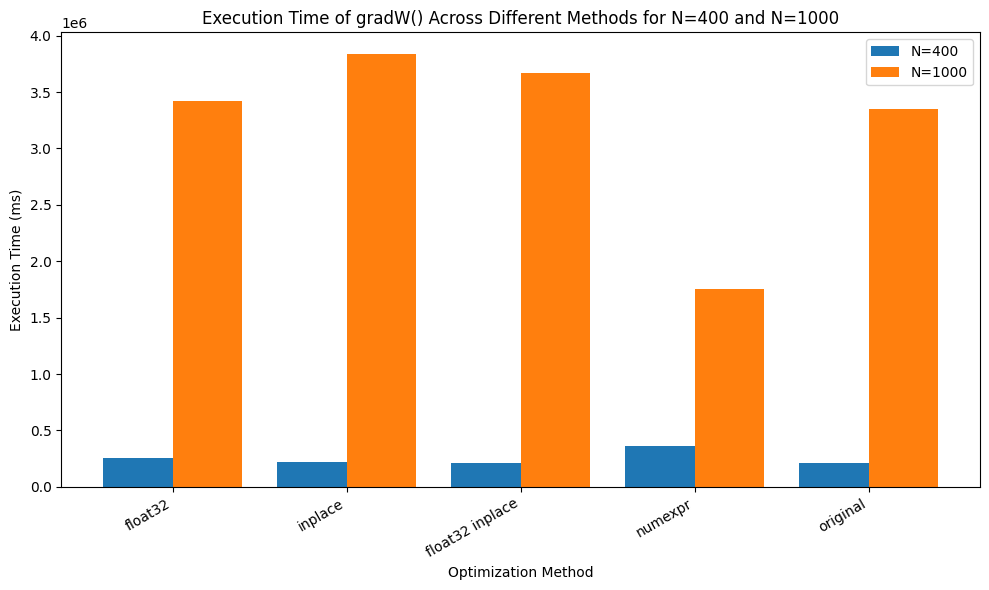

In [25]:
# Re-import necessary libraries since execution state was reset
import matplotlib.pyplot as plt
import numpy as np

# Define methods and their execution times for N=400 and N=1000
methods = ["float32", "inplace", "float32 inplace", "numexpr", "original"]

times_N400 = [252265, 216005, 209782, 358177, 209571]
times_N1000 = [3418635, 3837618, 3673374, 1756321, 3352266]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(methods))  # label positions
bar_width = 0.4

# Plot bars for N=400 and N=1000
ax.bar(x - bar_width/2, times_N400, bar_width, label="N=400", color='tab:blue')
ax.bar(x + bar_width/2, times_N1000, bar_width, label="N=1000", color='tab:orange')

ax.set_xlabel("Optimization Method")
ax.set_ylabel("Execution Time (ms)")
ax.set_title("Execution Time of gradW() Across Different Methods for N=400 and N=1000")
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=30, ha="right")
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

Next we hypothesis that the code is using a lot of memory, especially updating the same values again and again. Therefore, we thought that using memory_view could bring some speedup as such that now the memory chuncks would be next to each other and hopefully better / faster accessible. 

In [15]:
! pytest test_memory_view.py

============================= test session starts ==============================
platform darwin -- Python 3.11.6, pytest-8.3.4, pluggy-1.5.0
rootdir: /Users/carlottaholzle/Desktop/KTH Assignments/Computational-Astrophysics
collected 1 item                                                               

test_memory_view.py .                                                    [100%]

============================== 1 passed in 0.43s ===============================


First we now used the "winner" for each optimized method, collected the execution time and lastly compared all the execution times to see which approach gives the highest gain in processing speed. We are running with N=1000

In [29]:
! python -m cProfile -s cumulative sph_optimized.py

         1709882 function calls (1675933 primitive calls) in 15.971 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   1068/1    0.006    0.000   15.972   15.972 {built-in method builtins.exec}
        1    0.000    0.000   15.972   15.972 sph_optimized.py:1(<module>)
        1    0.614    0.614   15.447   15.447 sph_optimized.py:183(main)
      301    1.589    0.005   10.413    0.035 sph_optimized.py:139(getAcc)
      601    0.363    0.001    8.165    0.014 sph_optimized.py:106(getDensity)
      601    5.403    0.009    5.403    0.009 sph_optimized.py:13(W)
      301    3.425    0.011    3.425    0.011 sph_optimized.py:39(gradW)
      902    3.174    0.004    3.176    0.004 sph_optimized.py:59(getPairwiseSeparations)
      126    0.002    0.000    1.794    0.014 __init__.py:1(<module>)
   1159/5    0.003    0.000    0.799    0.160 <frozen importlib._bootstrap>:1165(_find_and_load)
   1154/5    0.003    0.000    0.799    

with optimizedW

In [30]:
! python -m cProfile -s cumulative sph_optimized.py

         1713774 function calls (1679829 primitive calls) in 13.242 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   1068/1    0.006    0.000   13.243   13.243 {built-in method builtins.exec}
        1    0.000    0.000   13.243   13.243 sph_optimized.py:1(<module>)
        1    0.594    0.594   12.697   12.697 sph_optimized.py:183(main)
      301    1.482    0.005    9.022    0.030 sph_optimized.py:139(getAcc)
      601    0.302    0.001    5.835    0.010 sph_optimized.py:106(getDensity)
      301    3.302    0.011    3.302    0.011 sph_optimized.py:39(gradW)
      601    2.815    0.005    3.158    0.005 sph_optimized.py:28(optimizedW)
      902    3.099    0.003    3.100    0.003 sph_optimized.py:59(getPairwiseSeparations)
      126    0.002    0.000    1.528    0.012 __init__.py:1(<module>)
   1159/5    0.003    0.000    0.734    0.147 <frozen importlib._bootstrap>:1165(_find_and_load)
   1154/5    0.003    0.000    

with optimizedgetpairwiseseperation 

In [31]:
! python -m cProfile -s cumulative sph_optimized.py

         1711218 function calls (1677269 primitive calls) in 11.047 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   1068/1    0.006    0.000   11.048   11.048 {built-in method builtins.exec}
        1    0.000    0.000   11.048   11.048 sph_optimized.py:1(<module>)
        1    0.380    0.380   10.511   10.511 sph_optimized.py:183(main)
      301    1.757    0.006    7.287    0.024 sph_optimized.py:139(getAcc)
      601    0.217    0.000    5.245    0.009 sph_optimized.py:106(getDensity)
      601    3.544    0.006    3.544    0.006 sph_optimized.py:13(W)
      301    2.061    0.007    2.061    0.007 sph_optimized.py:39(gradW)
      902    1.945    0.002    1.951    0.002 sph_optimized.py:86(getPairwiseSeparations_inplace)
      126    0.002    0.000    1.494    0.012 __init__.py:1(<module>)
   1159/5    0.003    0.000    0.721    0.144 <frozen importlib._bootstrap>:1165(_find_and_load)
   1154/5    0.003    0.000    0

with optimized gradW

In [4]:
! python -m cProfile -s cumulative sph_optimized.py

         1821062 function calls (1784269 primitive calls) in 13.537 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   1073/1    0.007    0.000   13.538   13.538 {built-in method builtins.exec}
        1    0.000    0.000   13.538   13.538 sph_optimized.py:1(<module>)
        1    0.556    0.556   12.808   12.808 sph_optimized.py:232(main)
      301    1.517    0.005    8.144    0.027 sph_optimized.py:188(getAcc)
      601    0.296    0.000    7.559    0.013 sph_optimized.py:155(getDensity)
      601    5.044    0.008    5.044    0.008 sph_optimized.py:14(W)
      902    3.068    0.003    3.069    0.003 sph_optimized.py:108(getPairwiseSeparations)
      127    0.004    0.000    2.352    0.019 __init__.py:1(<module>)
      301    0.004    0.000    1.549    0.005 sph_optimized.py:58(gradW_float32_ne)
     1806    0.007    0.000    1.544    0.001 necompiler.py:893(evaluate)
     1806    1.458    0.001    1.468    0.001 necom

In [24]:
! python -m cProfile -s cumulative sph_optimized.py

         1826354 function calls (1789291 primitive calls) in 8.774 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   1073/1    0.006    0.000    8.775    8.775 {built-in method builtins.exec}
        1    0.000    0.000    8.775    8.775 sph_optimized.py:1(<module>)
        1    0.365    0.365    8.219    8.219 sph_optimized.py:266(main)
      301    2.061    0.007    5.965    0.020 sph_optimized.py:222(getAcc)
      601    0.315    0.001    3.309    0.006 sph_optimized.py:189(getDensity)
      902    1.832    0.002    1.837    0.002 sph_optimized.py:169(getPairwiseSeparations_inplace)
      601    1.526    0.003    1.654    0.003 sph_optimized.py:29(optimizedW)
      127    0.002    0.000    1.521    0.012 __init__.py:1(<module>)
      301    0.003    0.000    1.368    0.005 sph_optimized.py:58(gradW_float32_ne)
     1806    0.006    0.000    1.364    0.001 necompiler.py:893(evaluate)
     1806    1.290    0.001    1.29

In [ ]:
# this is the memory_view implementation. 
! python -m cProfile -s cumulative memory_view.py

         1828123 function calls (1790968 primitive calls) in 10.934 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   10.935    5.467 data_structures.py:1(<module>)
   1078/1    0.006    0.000   10.935   10.935 {built-in method builtins.exec}
        1    0.430    0.430   10.373   10.373 data_structures.py:273(main)
      301    2.266    0.008    6.851    0.023 data_structures.py:232(getAcc)
      601    0.780    0.001    5.025    0.008 data_structures.py:127(getDensity)
      902    1.895    0.002    1.901    0.002 data_structures.py:107(getPairwiseSeparations_inplace)
      300    1.770    0.006    1.770    0.006 data_structures.py:11(W)
      128    0.002    0.000    1.643    0.013 __init__.py:1(<module>)
      301    0.004    0.000    1.404    0.005 data_structures.py:40(gradW_float32_ne)
     1806    0.007    0.000    1.400    0.001 necompiler.py:893(evaluate)
     1806    1.320    0.001  

# profiling getAcc with and without memoryview: 

In [27]:
! python -m kernprof -l sph_optimized.py 

Wrote profile results to sph_optimized.py.lprof
Inspect results with:
python -m line_profiler -rmt "sph_optimized.py.lprof"


In [28]:
! python -m line_profiler -rmt "sph_optimized.py.lprof"

Timer unit: 1e-06 s

Total time: 6.5132 s
File: sph_optimized.py
Function: getAcc at line 157

Line #      Hits         Time  Per Hit   % Time  Line Contents
   157                                           @profile
   158                                           def getAcc( pos, vel, m, h, k, n, lmbda, nu ):
   159                                           	"""
   160                                           	Calculate the acceleration on each SPH particle
   161                                           	pos   is an N x 3 matrix of positions
   162                                           	vel   is an N x 3 matrix of velocities
   163                                           	m     is the particle mass
   164                                           	h     is the smoothing length
   165                                           	k     equation of state constant
   166                                           	n     polytropic index
   167                                        

# profiling getAcc with memoryview and all optimizations 

In [ ]:
! python -m kernprof -l memory_view.py 

Wrote profile results to data_structures.py.lprof
Inspect results with:
python -m line_profiler -rmt "data_structures.py.lprof"


In [ ]:
! python -m line_profiler -rmt "memory_view.py.lprof"

Timer unit: 1e-06 s

Total time: 6.991 s
File: data_structures.py
Function: getAcc at line 231

Line #      Hits         Time  Per Hit   % Time  Line Contents
   231                                           @profile 
   232                                           def getAcc(pos, vel, m, h, k, n, lmbda, nu):
   233                                               """
   234                                               Calculate the acceleration on each SPH particle
   235                                               """
   236       301        363.0      1.2      0.0      N = pos.shape[0]
   237                                               
   238       301        555.0      1.8      0.0      pos = np.ascontiguousarray(pos)
   239       301         68.0      0.2      0.0      m = np.ascontiguousarray(m)
   240       301        217.0      0.7      0.0      h = np.ascontiguousarray(h)
   241       301         77.0      0.3      0.0      k = np.ascontiguousarray(k)
   242       301     

please write python code to plot the six stages: 
N=1000
orginal, with optimizedW, with optimizedGetPairwiseSeperations, with optimizedgradW, with all three together, with memoryview()
original: 15.414 seconds
optimizedW: 13.242 seconds
optimizedGetPairwiseSeperations: 11.047
optimizedGradW: 13.537
all_three: 8.774
memoryview() & optimized methods: 10.934 seconds

For N = 400 
with memoryview: 2.1
with all optimized: 1.9
original: 2.358

In [36]:
! python -m cProfile -s cumulative sph.py

         1689048 function calls (1655487 primitive calls) in 2.358 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   1027/1    0.005    0.000    2.359    2.359 {built-in method builtins.exec}
        1    0.000    0.000    2.359    2.359 sph.py:1(<module>)
        1    0.045    0.045    1.816    1.816 sph.py:154(main)
      123    0.002    0.000    1.618    0.013 __init__.py:1(<module>)
      301    0.138    0.000    1.101    0.004 sph.py:110(getAcc)
      601    0.019    0.000    0.880    0.001 sph.py:77(getDensity)
   1131/4    0.003    0.000    0.747    0.187 <frozen importlib._bootstrap>:1165(_find_and_load)
   1126/4    0.003    0.000    0.747    0.187 <frozen importlib._bootstrap>:1120(_find_and_load_unlocked)
   1080/6    0.002    0.000    0.746    0.124 <frozen importlib._bootstrap>:666(_load_unlocked)
    987/6    0.001    0.000    0.746    0.124 <frozen importlib._bootstrap_external>:934(exec_module)
   2567/9 

In [19]:
! python -m cProfile -s cumulative sph_optimized.py

         1826467 function calls (1789404 primitive calls) in 1.957 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   1073/1    0.006    0.000    1.958    1.958 {built-in method builtins.exec}
        1    0.000    0.000    1.958    1.958 sph_optimized.py:1(<module>)
      127    0.002    0.000    1.548    0.012 __init__.py:1(<module>)
        1    0.032    0.032    1.402    1.402 sph_optimized.py:202(main)
      301    0.242    0.001    0.945    0.003 sph_optimized.py:158(getAcc)
   1165/6    0.003    0.000    0.748    0.125 <frozen importlib._bootstrap>:1165(_find_and_load)
   1160/6    0.003    0.000    0.747    0.125 <frozen importlib._bootstrap>:1120(_find_and_load_unlocked)
   1113/8    0.002    0.000    0.746    0.093 <frozen importlib._bootstrap>:666(_load_unlocked)
   1011/8    0.001    0.000    0.746    0.093 <frozen importlib._bootstrap_external>:934(exec_module)
  2655/13    0.001    0.000    0.745    0.057 <f

In [ ]:
# only memoryview 
! python -m cProfile -s cumulative memory_view.py

         1693616 function calls (1659850 primitive calls) in 1.971 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      125    0.002    0.000    1.977    0.016 __init__.py:1(<module>)
        2    0.000    0.000    1.972    0.986 data_structures.py:1(<module>)
   1037/1    0.006    0.000    1.972    1.972 {built-in method builtins.exec}
        1    0.023    0.023    1.364    1.364 data_structures.py:237(main)
      301    0.176    0.001    1.061    0.004 data_structures.py:196(getAcc)
   1142/7    0.004    0.000    0.871    0.124 <frozen importlib._bootstrap>:1165(_find_and_load)
   1137/7    0.003    0.000    0.871    0.124 <frozen importlib._bootstrap>:1120(_find_and_load_unlocked)
   1091/8    0.002    0.000    0.870    0.109 <frozen importlib._bootstrap>:666(_load_unlocked)
    997/8    0.001    0.000    0.870    0.109 <frozen importlib._bootstrap_external>:934(exec_module)
  2595/13    0.001    0.000    0.869    0.

In [ ]:
# memory view + all optimized
! python -m cProfile -s cumulative data_structures.py

         1802016 function calls (1765249 primitive calls) in 2.095 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      125    0.002    0.000    2.282    0.018 __init__.py:1(<module>)
        2    0.000    0.000    2.096    1.048 data_structures.py:1(<module>)
   1037/1    0.006    0.000    2.096    2.096 {built-in method builtins.exec}
        1    0.035    0.035    1.437    1.437 data_structures.py:237(main)
      301    0.248    0.001    1.055    0.004 data_structures.py:196(getAcc)
   1142/7    0.004    0.000    0.988    0.141 <frozen importlib._bootstrap>:1165(_find_and_load)
   1137/7    0.003    0.000    0.988    0.141 <frozen importlib._bootstrap>:1120(_find_and_load_unlocked)
   1091/8    0.003    0.000    0.987    0.123 <frozen importlib._bootstrap>:666(_load_unlocked)
    997/8    0.002    0.000    0.987    0.123 <frozen importlib._bootstrap_external>:934(exec_module)
  2595/13    0.001    0.000    0.986    0.

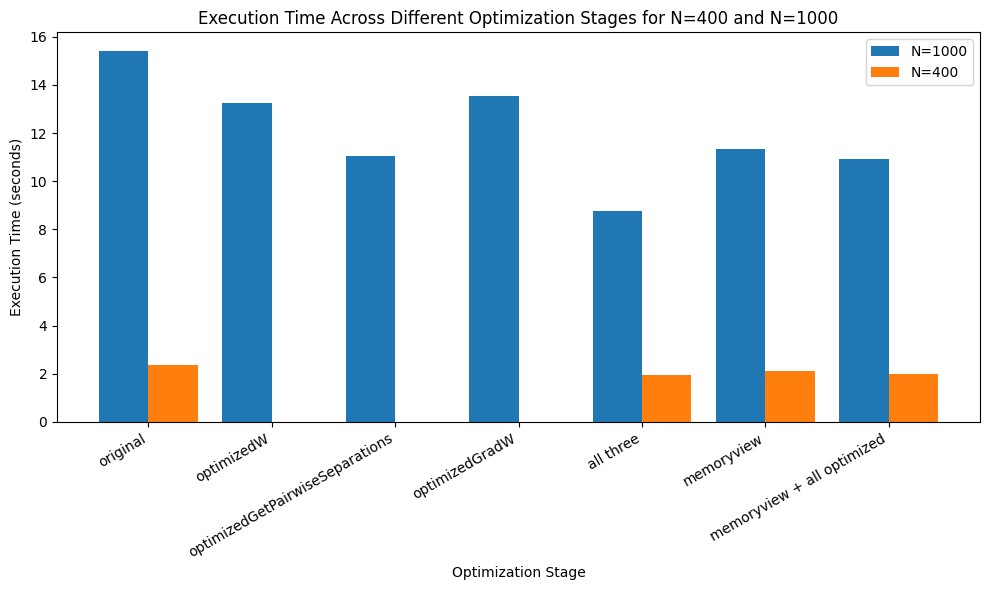

In [21]:
# Re-import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Define stages and their execution times for N=400 and N=1000
stages = [
    "original",
    "optimizedW",
    "optimizedGetPairwiseSeparations",
    "optimizedGradW",
    "all three",
    "memoryview",
    "memoryview + all optimized"
]

times_N1000 = [15.414, 13.242, 11.047, 13.537, 8.774, 11.333, 10.934]
times_N400 = [2.358, None, None, None, 1.957,2.095, 1.971] 

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(stages))  # label positions
bar_width = 0.4

# Ensure missing values (None) are replaced with zero for plotting
times_N400_filled = [t if t is not None else 0 for t in times_N400]

# Plot bars for N=400 and N=1000
ax.bar(x - bar_width/2, times_N1000, bar_width, label="N=1000", color='tab:blue')
ax.bar(x + bar_width/2, times_N400_filled, bar_width, label="N=400", color='tab:orange')

ax.set_xlabel("Optimization Stage")
ax.set_ylabel("Execution Time (seconds)")
ax.set_title("Execution Time Across Different Optimization Stages for N=400 and N=1000")
ax.set_xticks(x)
ax.set_xticklabels(stages, rotation=30, ha="right")
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

Memory_view alone, without other optimizeaiton, is slightly faster using small N but for large N it is not. 

only memoryview: N = 1000

In [42]:
! python -m cProfile -s cumulative data_structures.py

         1714775 function calls (1680621 primitive calls) in 11.333 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   11.334    5.667 data_structures.py:1(<module>)
   1078/1    0.006    0.000   11.334   11.334 {built-in method builtins.exec}
        1    0.328    0.328   10.790   10.790 data_structures.py:278(main)
      301    2.327    0.008   10.118    0.034 data_structures.py:237(getAcc)
      301    0.436    0.001    3.432    0.011 data_structures.py:132(getDensity)
      301    3.317    0.011    3.317    0.011 data_structures.py:31(gradW)
      301    2.235    0.007    2.236    0.007 data_structures.py:11(W)
      128    0.002    0.000    2.018    0.016 __init__.py:1(<module>)
      602    1.285    0.002    1.289    0.002 data_structures.py:91(getPairwiseSeparations)
   1170/8    0.003    0.000    0.870    0.109 <frozen importlib._bootstrap>:1165(_find_and_load)
   1165/8    0.003    0.00